In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sklearn.model_selection
import cv2

# SYDE 522 Final Project

## By Anirudh Kilambi and Youngwoo Lee

The purpose of this project is to apply techniques used in class to detect and identify faults and defects found in sewer pipelines. To accomplish this, we used training data found from the 2022 VideoPipe challenge for Real-World Video Understanding for Urban Pipe Inspection. For this project, we investigated the effectiveness of Convolutional Neural Networks (CNN) and Support Vector Machines (SVM) in order to come to an experimental conclusion on which model is most effective for this task.

## Data Loading

In [9]:
raw_data_path = "data/raw_images/"
categorization = [("4736", 0), ("2383", 0), ("d20017", 1), ("26852", 1)]
print(os.listdir("data/raw_images/"))

folders = os.listdir(raw_data_path)
sewer_data = {}
sewer_data["data"] = []
sewer_data["target"] = []

for folder, cat in categorization:
    images = os.listdir(f"{raw_data_path}{folder}/")
    for image in images:
        sewer_data["data"].append(f"{raw_data_path}{folder}/{image}")
        sewer_data["target"].append(cat)

    
x = sewer_data["data"]
y = sewer_data["target"]

x_trainvalid, x_test, y_trainvalid, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)

x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)

print(len(y), len(y_train,), len(y_test), len(y_valid))
print(x[1].split("/")[2])

['d10169', '551', 'd3081', '26640_1', 'd7283', 'd20159', 'd5188', 'd15844', '1899', 'd3249', '27080', '4720', 'd17177', '25340', '2013', 'd20567', 'd9149', 'd23991_1', '26525_1', '26902', 'd21674', '26375_1', '3132', 'd5121', '2680', '2479', 'd17911', '26795', 'd5779', 'd4835', '330', 'd3419', 'd22265', '3352', 'd15619', 'd21621', 'd15242', '308', '3193', 'd3421', 'd7418', 'd5142', 'd23140', '5252', '1898', '762', '26995', 'd18761', 'd4635', 'd16092', 'd5145', '27010', '4929', 'd11228', '504', 'd6793', 'd15220', 'd23584', 'd18356', '27696_1', 'd15811', '26390_3', '4786', '26218_2', '3339', '1944', 'd84141', 'd18215', 'd16182', 'd24217_4', '26490_2', '4855', 'd5260', 'd18823', 'd22729', '5380', 'd23903_8', '688', 'd21709', '.DS_Store', 'd15990', 'd18678', 'd5635', 'd6276', '3672', 'd21134', 'd8942', '3216', 'd23238', 'd4324', 'd10680', 'd6641', '27767', 'd21568', 'd17655', 'd4785', 'd6670', '4806', '27684_2', '414', '26594_2', '27740_1', '3071', 'd23060', 'd7967', 'd23631', 'd5065', 'd2

In [10]:
def moveFiles(x,y,type):
    xpath = f"data/{type}/0/"
    ypath = f"data/{type}/1/"
    if not os.path.exists(xpath):
        os.makedirs(xpath)
    if not os.path.exists(ypath):
        os.makedirs(ypath)
    
    for i in range(len(x)):
        x_split = x[i].split("/")
        img_name = x_split[2] + x_split[3]

        if y[i] == 0:
            os.system(f"cp {x[i]} {xpath}/{img_name}")
        else:
            os.system(f"cp {x[i]} {ypath}/{img_name}")

moveFiles(x_train, y_train, "train")
moveFiles(x_test, y_test, "test")
moveFiles(x_valid, y_valid, "valid")

In [42]:
base_path = f"data"
types = ["valid", "train", "test"]
for type in types:
    type_base_path = f"{base_path}/{type}/"
    categories = os.listdir(type_base_path)
    for category in categories:
        category_base_path = f"{type_base_path}{category}/"
        images = os.listdir(category_base_path)
        for image in images:
            image_path = f"{category_base_path}{image}"
            print(image_path)
            img = cv2.imread(image_path)
            resized_image = cv2.resize(img, (640, 360))
            print(resized_image)
            cv2.imwrite(image_path, resized_image)


data/valid/0/473613.jpg
[[[149 152 160]
  [151 154 162]
  [113 116 124]
  ...
  [ 46  65  80]
  [ 59  78  93]
  [ 54  73  88]]

 [[135 138 146]
  [127 130 138]
  [165 168 176]
  ...
  [ 71  90 105]
  [ 65  84  99]
  [ 47  66  81]]

 [[144 147 155]
  [138 141 149]
  [198 201 209]
  ...
  [115 134 149]
  [118 137 152]
  [120 139 154]]

 ...

 [[117 143 159]
  [100 126 142]
  [112 138 154]
  ...
  [101 107 106]
  [ 99 105 104]
  [ 99 105 104]]

 [[116 145 160]
  [106 135 150]
  [112 138 154]
  ...
  [104 110 109]
  [102 108 107]
  [100 106 105]]

 [[111 140 155]
  [103 132 147]
  [103 129 145]
  ...
  [101 107 106]
  [100 106 105]
  [ 98 104 103]]]
data/valid/0/4736223.jpg
[[[251 230 222]
  [252 231 223]
  [252 231 223]
  ...
  [ 63  70  73]
  [ 62  69  72]
  [ 62  69  72]]

 [[252 231 223]
  [252 231 223]
  [252 231 223]
  ...
  [ 63  70  73]
  [ 62  69  72]
  [ 62  69  72]]

 [[252 231 223]
  [252 231 223]
  [252 231 223]
  ...
  [ 63  70  73]
  [ 62  69  72]
  [ 60  69  72]]

 ...

 [[

In [43]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/train/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1000,
    image_size=(640, 360))

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/test/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1000,
    image_size=(640, 360))

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/valid/',
    labels='inferred',
    label_mode='categorical',
    batch_size=1000,
    image_size=(640, 360))

print(valid_ds)

Found 852 files belonging to 2 classes.
Found 214 files belonging to 2 classes.
Found 214 files belonging to 2 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 640, 360, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


## Part 1: Convolutional Neural Networks 

Epoch 1/5


/Users/Anirudh.Kilambi/.virtualenvs/etl/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Users/Anirudh.Kilambi/.virtualenvs/etl/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8345 - loss: 9171.5850 - val_accuracy: 0.6168 - val_loss: 0.5000
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6279 - loss: 0.5000 - val_accuracy: 0.6168 - val_loss: 0.5000
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6279 - loss: 0.5000 - val_accuracy: 0.6168 - val_loss: 0.5000
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6279 - loss: 0.5000 - val_accuracy: 0.6168 - val_loss: 0.5000
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6279 - loss: 0.5000 - val_accuracy: 0.6168 - val_loss: 0.5000


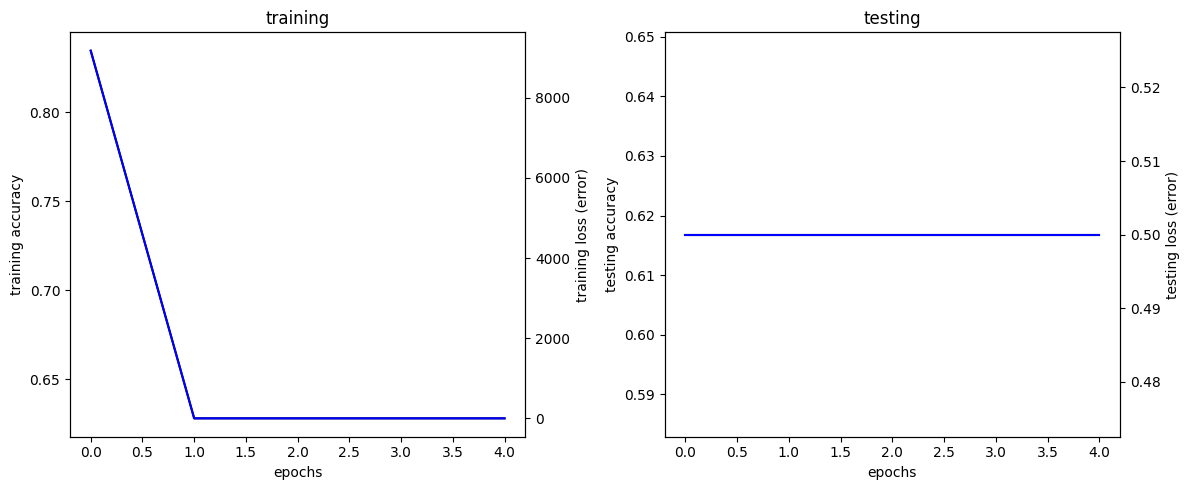

In [46]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape = (640, 360, 3)),
  tf.keras.layers.Flatten(input_shape=(640, 360, 3)),   
  tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
  tf.keras.layers.Dense(2, activation='relu')     # 10 outputs (one for each category)
])

def my_loss(y_true, y_predict):
    return (y_true-y_predict)**2

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
              # loss='categorical_crossentropy',
              loss=my_loss,
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )

model.fit(train_ds, epochs=5, validation_data=test_ds)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()